In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### unzipping

!unzip -u "/content/drive/MyDrive/Defance/pad augmanted dataset.zip" -d "/content"

print('\ndone!')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [ ]:
labels = ["images_01", "images_02"]
img_size = 32
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:

train = get_data('/content/drive/MyDrive/Dataset orginial/x-rey')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


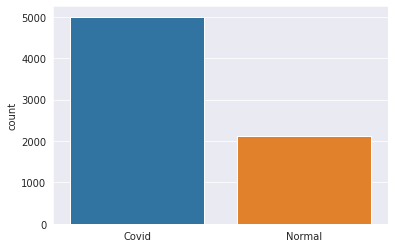

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Covid")
    elif(i[1] == 1):
          l.append("Normal")
    else :
        l.append("Viral Pneumonia")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'images_01')

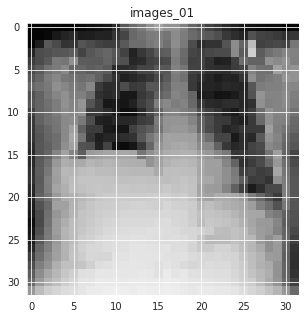

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

In [ ]:
x_train = []
y_train = []


for feature, label in train:
  x_train.append(feature)
  y_train.append(label)
x_train = np.array(x_train) / 255
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)


In [ ]:
print(x_train.shape)

(7126, 32, 32, 3)


In [ ]:
# split with a stratified sampling
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(x_train, y_train,
    test_size=0.3, stratify=y_train, random_state=42)

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 3
input_shape = (32, 32, 3)

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4988, 32, 32, 3) - y_train shape: (4988,)
x_test shape: (2138, 32, 32, 3) - y_test shape: (2138,)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


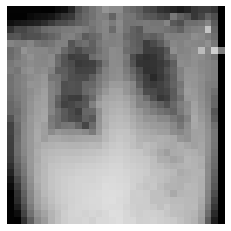

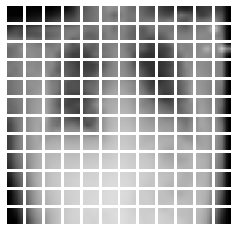

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("float"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("float"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    from sklearn.metrics import classification_report, confusion_matrix

    # as I've trained my model on MNIST as odd or even (binary classes)
    target_names = ["ACK", "BCC", "MEL","NEV","SCC","SEK"]


    # get predict prob and label 
    ypred = model.predict(x_test, verbose=1)
    ypred = np.argmax(ypred, axis=1)
    print(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names))
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd 

    cm = confusion_matrix(np.argmax(y_test, axis=1), ypred)
    cm = pd.DataFrame(cm, range(6),range(6))
    plt.figure(figsize = (10,10))

    sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
    plt.show()
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/5
18/18 [==============================] - 305s 16s/step - loss: 3.1819 - accuracy: 0.5781 - top-5-accuracy: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.5731 - val_top-5-accuracy: 1.0000
Epoch 2/5
18/18 [==============================] - 289s 16s/step - loss: 0.7424 - accuracy: 0.6351 - top-5-accuracy: 1.0000 - val_loss: 0.6174 - val_accuracy: 0.6934 - val_top-5-accuracy: 1.0000
Epoch 3/5
18/18 [==============================] - 291s 16s/step - loss: 0.6798 - accuracy: 0.6650 - top-5-accuracy: 1.0000 - val_loss: 0.6451 - val_accuracy: 0.6934 - val_top-5-accuracy: 1.0000
Epoch 4/5
18/18 [==============================] - 292s 16s/step - loss: 0.6530 - accuracy: 0.6699 - top-5-accuracy: 1.0000 - val_loss: 0.6212 - val_accuracy: 0.6914 - val_top-5-accuracy: 1.0000
Epoch 5/5
67/67 [==============================] - 42s 620ms/step - loss: 0.6120 - accuracy: 0.7025 - top-5-accuracy: 1.0000
Test accuracy: 70.25%
Test top 5 accuracy: 100.0%


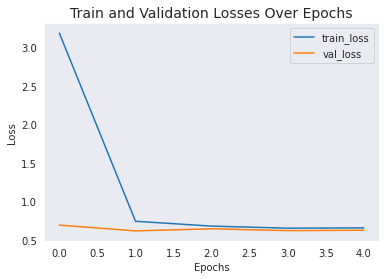

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()